# XOPT - INTERPRETABLE METAHEURISTICS FOR COMBINATORIAL OPTIMIZATION

## EXPLORATORY ANALYSIS

This notebook demonstrates how to use the Python extension `xopt` to solve instances of the p-median problem with the `kmedoids` and `tspmed` algorithms.

### SETTING THE ENVIRONMENT

Importing the libraries:

In [1]:
import xopt

import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.cluster      import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor, \
                                 DecisionTreeClassifier

from sklearn.model_selection import KFold
from sklearn.tree            import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics         import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler

This cell locates the "instances" folder in the project root and counts how many p-median instance files exist:

In [2]:
ROOT          = Path.cwd().resolve().parent
INSTANCES_DIR = ROOT / "instances"

if not INSTANCES_DIR.exists():
    raise FileNotFoundError(f"Instances folder not found: {INSTANCES_DIR}")

print(f"Total number of p-median instances: {len(list(INSTANCES_DIR.glob('pmed[0-9]*.txt')))}")

Total number of p-median instances: 40


### AUXILIARY FUNCTIONS

We define utilities to load instances, run the algorithms, and organize the results into user-friendly structures:

In [3]:
def to_one_based(indices):
    return [v + 1 for v in indices]

def to_binary(indices, n):
    binary = [0] * n

    for i in indices:
        binary[i] = 1

    return binary


def solve_pmedian(instance_path, *, restarts=10, max_iter=20, factor=2):
    instance = xopt.Instance(instance_path)

    n = instance.get_n()
    p = instance.get_p()

    medoids_runs = xopt.kmedoids(
        instance,
        max_iter=max_iter,
        restarts=restarts,
    )
    long_term    = xopt.SolutionTrie(n, p)

    ts_results = []
    for medoids in medoids_runs:
        ts_results.append(
            xopt.tspmed(
                instance       ,
                medoids.medoids,
                iter_factor=factor   ,
                long_term  =long_term,
            ).best
        )

    best_kmedoids = min(medoids_runs, key=lambda run: run.cost)
    best_tspmed   = min(ts_results  , key=lambda run: run.cost)

    long_term_mem = long_term.get_all_solutions(instance)

    summary = {
        "instance" : instance_path,
        "n"        : n,
        "p"        : p,

        "kmedoids_cost"     : best_kmedoids.cost,
        "tspmed_cost"       : best_tspmed  .cost,
        "long_term_mem"     : len         (long_term_mem           ),
        "medoids"           : to_one_based(best_kmedoids.medoids   ),
        "tspmed_facilities" : to_one_based(best_tspmed  .facilities),
    }

    details = {
        "medoids": [
            {
                "restart" : idx     ,
                "cost"    : run.cost,
                "medoids" : to_binary(run.medoids, n),
            }
            for idx, run in enumerate(medoids_runs)
        ],
        "tspmed": [
            {
                "restart"    : idx        ,
                "cost"       : result.cost,
                "facilities" : to_binary(result.facilities, n),
            }
            for idx, result in enumerate(ts_results)
        ],
        "long_term_memory": [
            {
                "cost"       : sol.cost,
                "facilities" : to_binary(sol.facilities, n),
            }
            for sol in long_term_mem
        ],
    }

    return summary, details

### APPLYING

We selected a few classic p-median instances and recorded the results obtained:

In [4]:
instance      = "pmed11.txt"
instance_path = str(INSTANCES_DIR / instance)

summary, details = solve_pmedian(instance_path,
                                 restarts=8 ,
                                 max_iter=25,
                                 factor  =2 )

print(f"Instance {summary['instance'][:-4]} ({summary['p']}-{summary['n']})")

print()
print(f"  K-Medoids ({summary['kmedoids_cost']}): {summary['medoids'          ][:10]}")
print(f"  TSPMED    ({summary['tspmed_cost'  ]}): {summary['tspmed_facilities'][:10]}")

print()
print(f"Obs.: Distinct solutions recorded in long term memory is {summary['long_term_mem']}!")

Instance /home/rei-luisinho/xopt/instances/pmed11 (5-300)

  K-Medoids (7696.0): [201, 98, 167, 24, 31]
  TSPMED    (7696.0): [201, 98, 167, 24, 31]

Obs.: Distinct solutions recorded in long term memory is 789!


### EDA - LONG-TERM MEMORY

The figure displays a binary heatmap of all solutions stored in the long-term memory:

- Each row corresponds to one solution, and each column represents a facility;
- Black cells indicate facilities selected in that solution `(value = 1)`;
- White cells indicate facilities not selected `(value = 0)`.

> Obs.: This visualization helps reveal patterns such as frequently chosen facilities, recurring solution structures, and the overall diversity of the stored solutions.

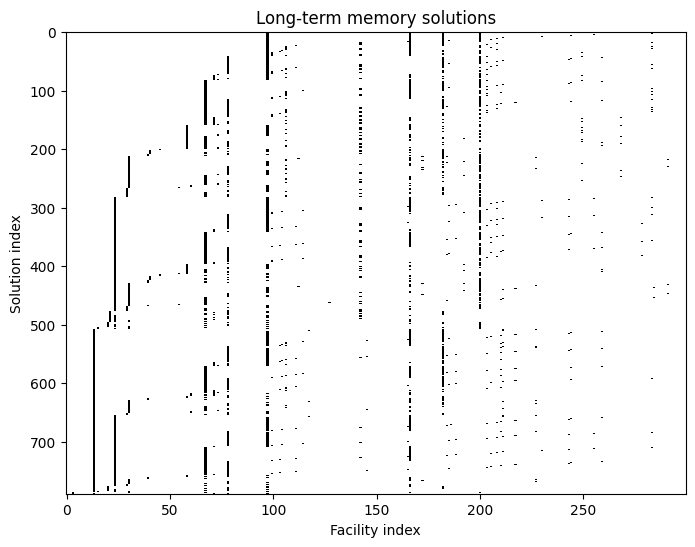

In [5]:
matrix = np.vstack(
    [
        np.array(sol["facilities"])
        for sol in details["long_term_memory"]
    ]
)

plt.figure(figsize=(8, 6))
plt.imshow(matrix,
           cmap         ="binary" ,
           aspect       ="auto"   ,
           interpolation="nearest")

plt.xlabel("Facility index")
plt.ylabel("Solution index")
plt.title ("Long-term memory solutions")

plt.show()

This cell sorts the solutions by cost, updates the matrix accordingly, and displays the ordered heatmap. It also computes meaningful Y-axis ticks—handling both varying and identical costs—to show representative cost values alongside the sorted solutions.

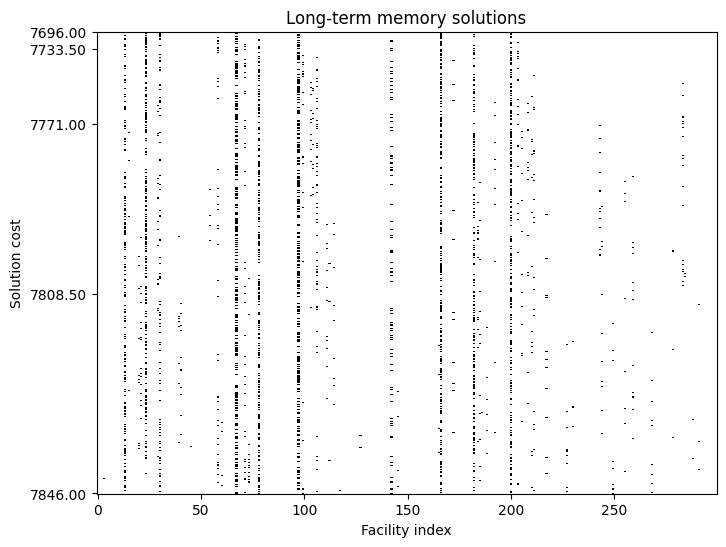

In [6]:
costs   = np.array(
    [
        sol["cost"]
        for sol in details["long_term_memory"]
    ],
    dtype=float
)
indices = np.argsort(costs)

matrix = matrix[indices]
costs  = costs [indices]


fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(matrix,
          cmap         ="binary" ,
          aspect       ="auto"   ,
          interpolation="nearest")

plt.xlabel("Facility index")
plt.ylabel("Solution cost" )
plt.title ("Long-term memory solutions")

min_cost, max_cost = costs.min(), costs.max()
if np.isclose(min_cost, max_cost):
    tick_positions = np.linspace(0, len(costs) - 1, 5)
    tick_costs     = np.full    (5, min_cost)
else:
    span = max_cost - min_cost

    tick_costs = np.array([
        min_cost,
        min_cost + 0.25 * span,
        min_cost + 0.50 * span,
        min_cost + 0.75 * span,
        max_cost,
    ])

    tick_positions = np.searchsorted(costs, tick_costs, side="left"   )
    tick_positions = np.clip        (tick_positions, 0, len(costs) - 1)

ax.set_yticks     (tick_positions)
ax.set_yticklabels([f"{c:.2f}" for c in tick_costs])

plt.show()

This cell analyzes the frequency of facility selections across all solutions stored in the long-term memory. It counts how many times each facility appears in the optimal solutions and visualizes this distribution using a bar chart.

The analysis helps identify:

- **Critical facilities**: Those that appear in many solutions, indicating their importance to the optimization problem
- **Rarely selected facilities**: Those with low occurrence counts, which might be suboptimal choices

The resulting visualization makes it easy to spot facilities that are essential components of good solutions for this p-median instance.

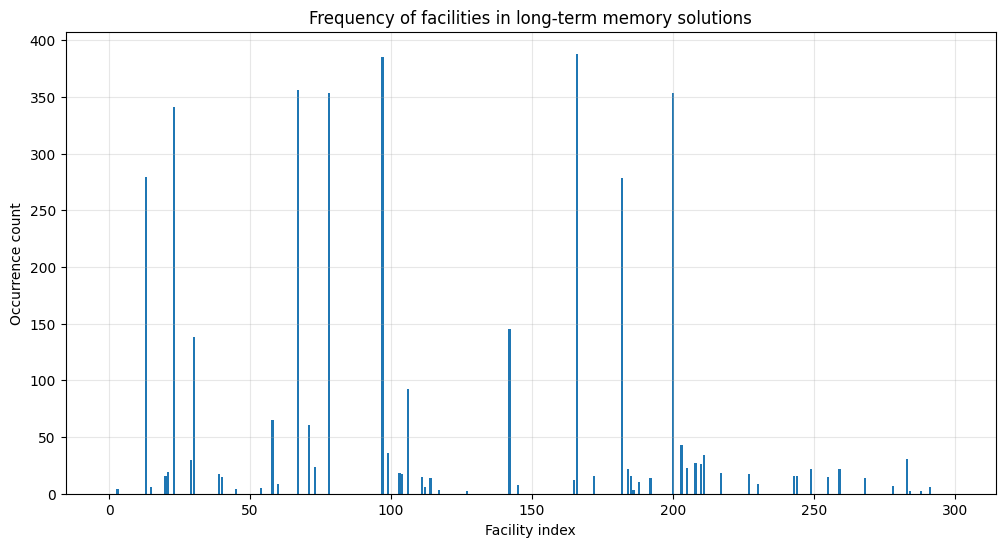

In [7]:
facility_counts = np.zeros(summary['n'], dtype=int)

for sol in details["long_term_memory"]:
    for idx, facility in enumerate(sol["facilities"]):
        if facility == 1:
            facility_counts[idx] += 1

plt.figure(figsize=(12, 6))

plt.bar (range(summary['n']), facility_counts)
plt.grid(True, alpha=0.3)

plt.xlabel("Facility index"  )
plt.ylabel("Occurrence count")
plt.title ("Frequency of facilities in long-term memory solutions")

plt.show()

### GROUPING BY SOLUTION VALUE

This cell applies the K-Means algorithm to the vector of solution costs for different values of k (from 2 to 10) and records the resulting inertia for each clustering. It then plots the inertia curve, known as the Elbow Method, which helps determine the most suitable number of clusters by identifying where the decrease in inertia begins to level off.

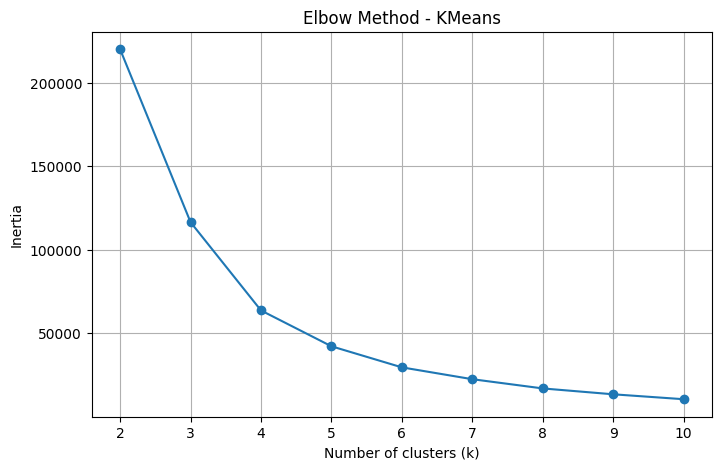

In [8]:
K    = range(2, 11)
data = costs.reshape(-1, 1)

inertias = []
for k in K:
    kmeans = KMeans(
        n_clusters  =k ,
        random_state=42,
    )
    kmeans.fit(data)

    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot  (K, inertias, marker='o')

plt.title ("Elbow Method - KMeans" )
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid  (True)

plt.show()

This section visualizes how the solution costs are grouped under different values of k by applying K-Means clustering and plotting the clusters for each choice of k.

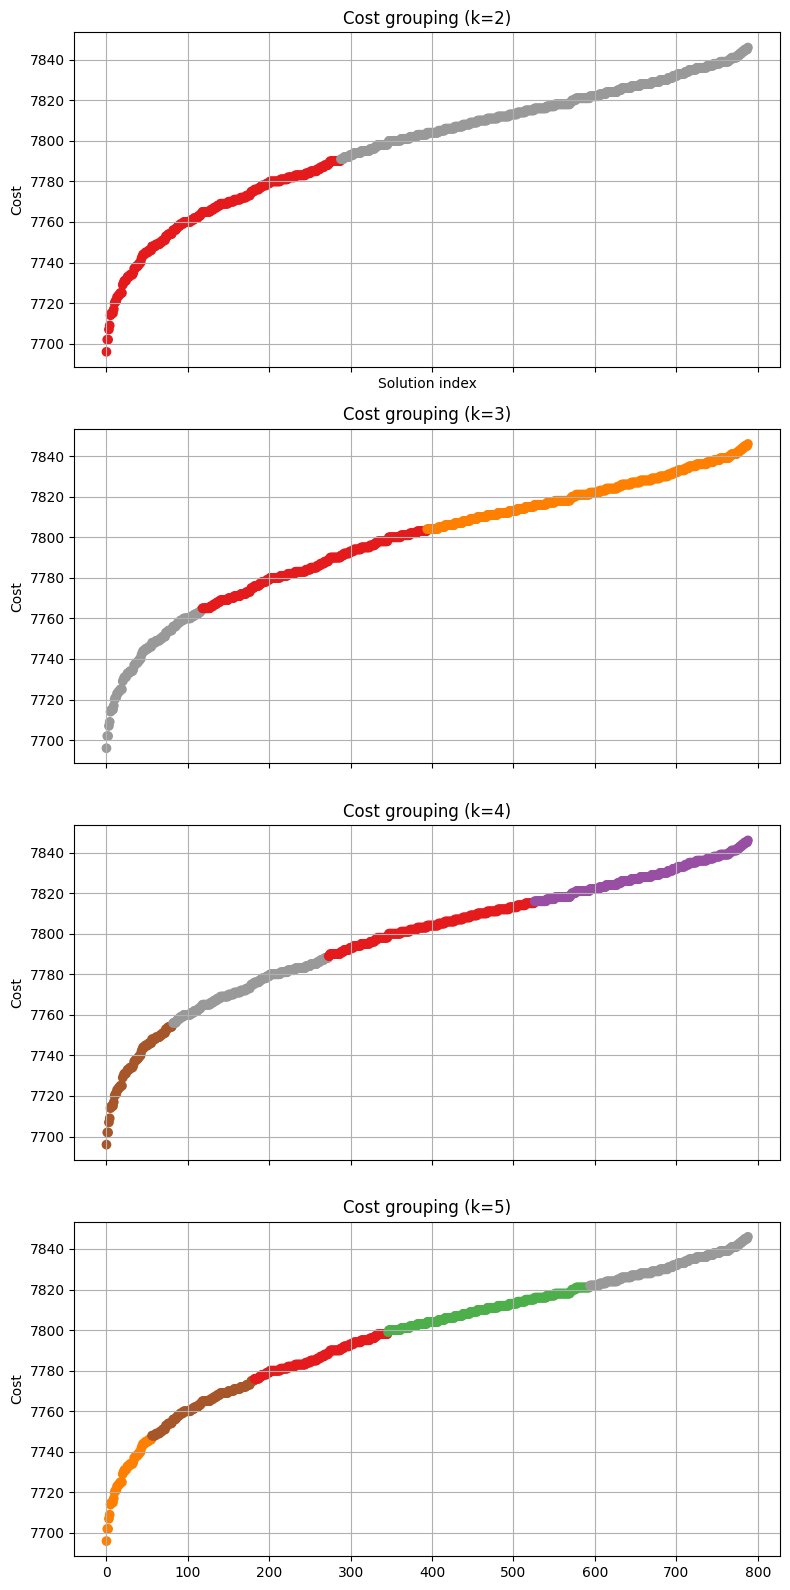

In [9]:
K       = range(2, 6)
n_plots = len  (K)

fig, axes = plt.subplots(n_plots, 1, figsize=(8, 4 * n_plots), sharex=True)

for ax, k in zip(axes, K):
    kmeans = KMeans(
        n_clusters  =k ,
        random_state=42
    ).fit(data)
    labels = kmeans.labels_

    ax.scatter(range(len(costs)), costs, c=labels, cmap='Set1')

    ax.set_title (f"Cost grouping (k={k})")
    ax.set_ylabel("Cost")
    ax.grid(True)

axes[0].set_xlabel("Solution index")

plt.tight_layout()
plt.show()

This cell clusters the solution costs for different values of k and shows, via boxplots, how the cost values are distributed within each cluster.

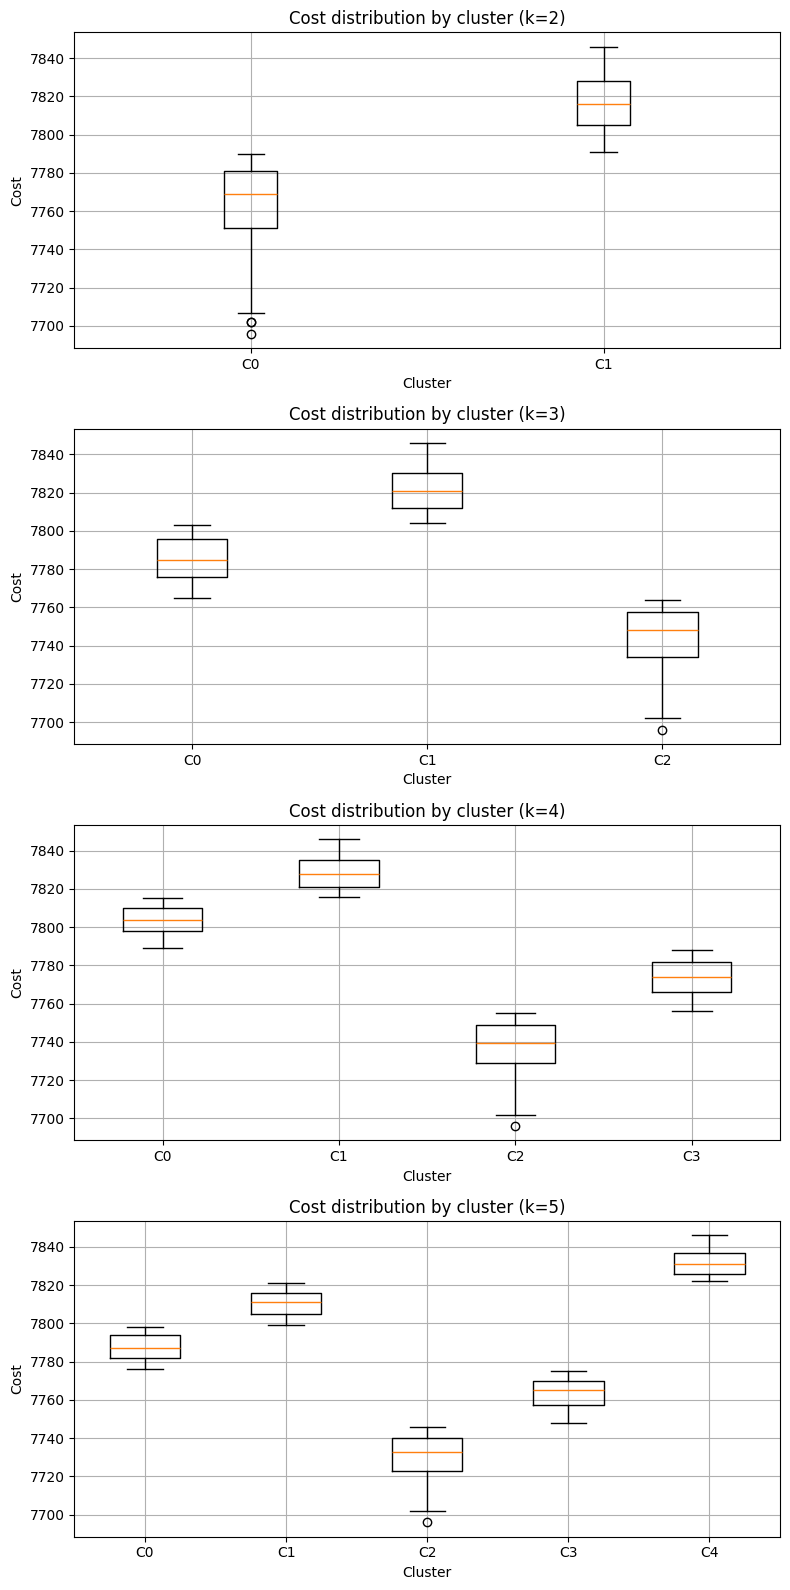

In [10]:
K       = range(2, 6)
n_plots = len  (K)

fig, axes = plt.subplots(n_plots, 1, figsize=(8, 4 * n_plots))

for ax, k in zip(axes, K):
    kmeans = KMeans(
        n_clusters  =k ,
        random_state=42
    ).fit(data)
    labels = kmeans.labels_

    clusters = [
        costs[labels == i]
        for i in range(k)
    ]

    ax.boxplot(clusters, tick_labels=[f"C{i}" for i in range(k)])

    ax.set_title (f"Cost distribution by cluster (k={k})")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Cost"   )
    ax.grid      (True)

plt.tight_layout()

plt.show()

Visualize each cluster's solution patterns, sorted by their average cost, using heatmaps to compare structure and quality across clusters:

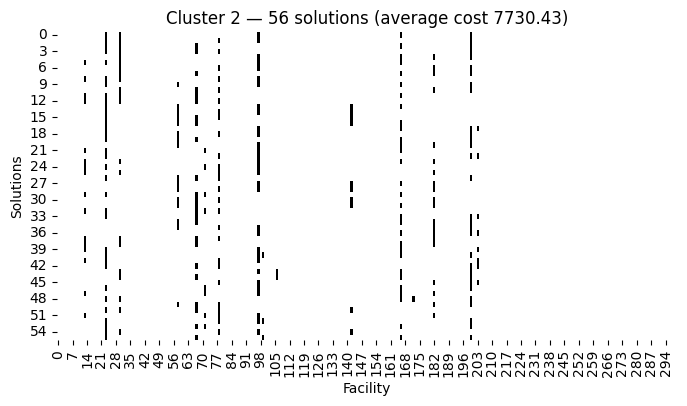

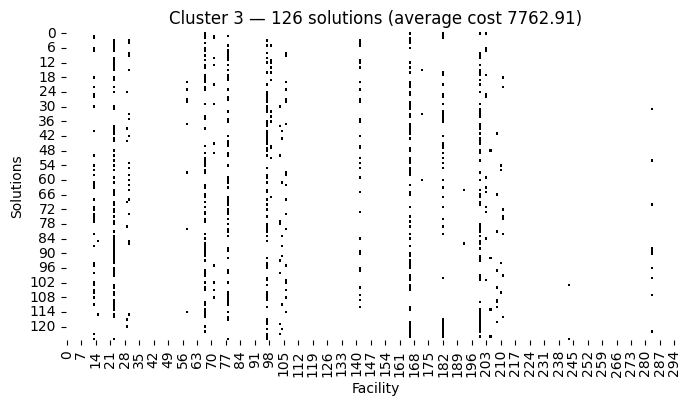

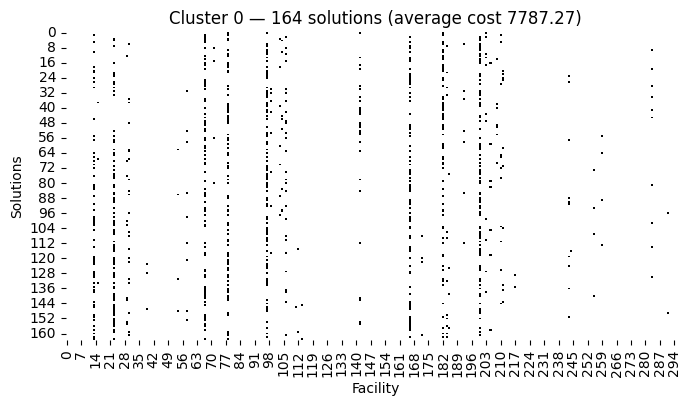

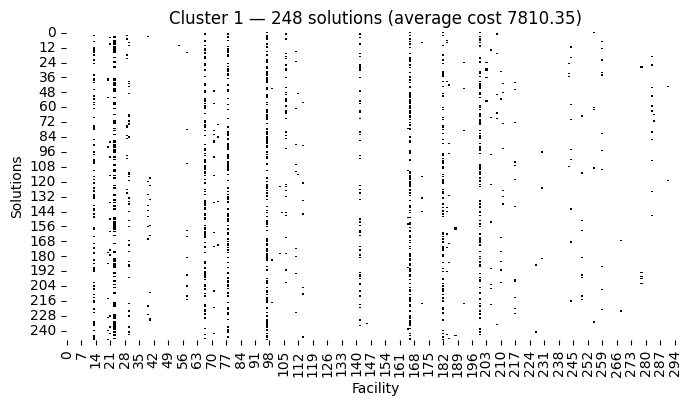

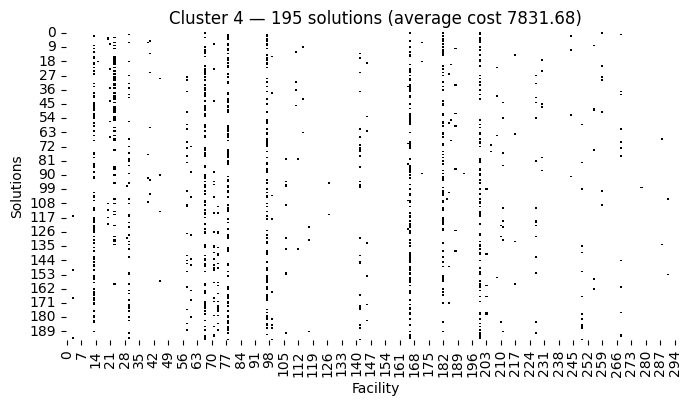

In [11]:
K = 5

cluster_info = []
for c in range(K):
    idx       = np.where(labels == c)[0]
    mean_cost = costs[idx].mean()

    cluster_info.append((c, mean_cost, idx))

cluster_info.sort(key=lambda x: x[1])

for c, mean_cost, idx in cluster_info:
    cluster_matrix = matrix[idx]

    plt.figure(figsize=(8, 4))

    sns.heatmap(cluster_matrix, cmap="binary", cbar=False)

    plt.title (f"Cluster {c} — {len(idx)} solutions (average cost {mean_cost:.2f})")
    plt.xlabel("Facility" )
    plt.ylabel("Solutions")

    plt.show()

Compute and display the average cost of each cluster, then identify which cluster achieves the lowest (best) average cost:

In [12]:
X = matrix.copy()

cluster_means = {c: costs[labels == c].mean()
                 for c in np.unique(labels)}
best_cluster  = min(cluster_means, key=cluster_means.get)

print("Average cost per cluster:")
for c, v in cluster_means.items():
    print(f"Cluster {c} = {v:.2f}")

print()
print("Optimal cluster (lowest average cost):", best_cluster)

Average cost per cluster:
Cluster 0 = 7787.27
Cluster 1 = 7810.35
Cluster 2 = 7730.43
Cluster 3 = 7762.91
Cluster 4 = 7831.68

Optimal cluster (lowest average cost): 2


### PREDICTION OF THE BEST CLUSTER

Classifying whether a given solution belongs to the cluster of best solutions:

In [13]:
X = matrix.copy()
y = np.array(labels == best_cluster, dtype="int8")

X, y = RandomUnderSampler(
    random_state=42
).fit_resample(X, y)

ccp_alphas = DecisionTreeClassifier(
    random_state=42
).cost_complexity_pruning_path(X, y)['ccp_alphas']

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=42       ,
        ccp_alpha   =ccp_alpha,
    )
    clf.fit(X, y)

    clfs.append(clf)

clf = clfs[-2] if len(clfs) > 1 else clfs[0]

print("Accuracy =", clf.score(X, y))
print(f"Max depth        = {clf.get_depth   ()}")
print(f"Number of leaves = {clf.get_n_leaves()}")

Accuracy = 0.8125
Max depth        = 4
Number of leaves = 5


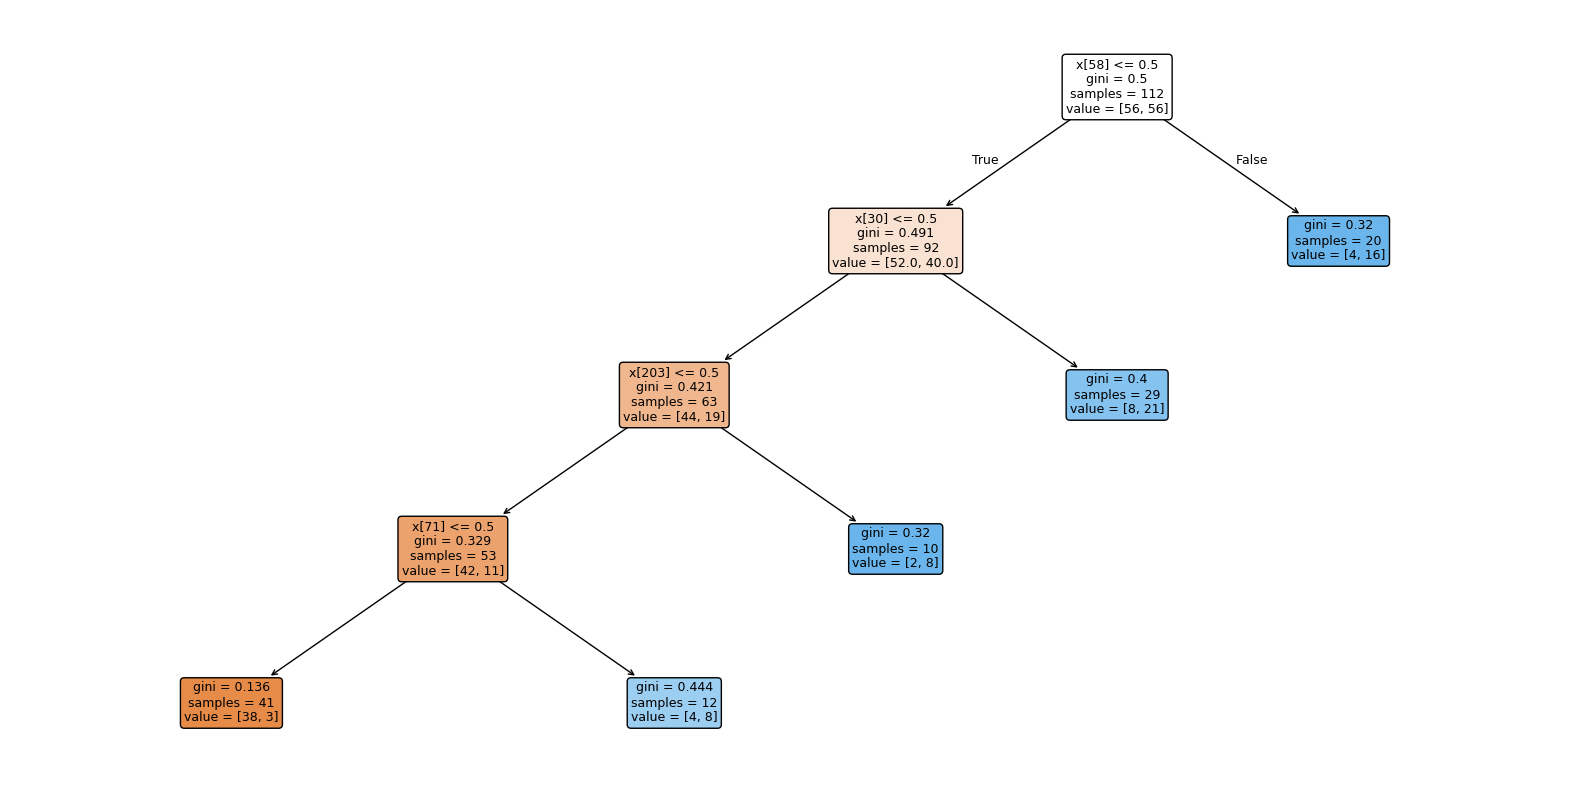

In [14]:
plt.figure(figsize=(20, 10))

plot_tree(
    clf,
    filled  =True,
    rounded =True,
    fontsize=9
)

plt.show()

### REGRESSION ANALYSIS BY LINEAR REGRESSION

The **R² score** measures how much of the variance in solution cost is explained by facility presence, since the score is computed on the training data, it reflects *fit quality*, not necessarily generalization.

- Values close to **1.0** indicate that facility selection strongly determines cost.
- Lower values suggest that cost depends on interactions or nonlinear effects not captured by the linear model.

The **intercept** represents the baseline cost when no facilities are selected (or when all predictors are zero). In practice, it can be interpreted as:

- A structural base cost of the instance, or
- A statistical offset required to align the linear model with observed costs.

In [15]:
X_regression = np.array([sol["facilities"] for sol in details["long_term_memory"]], dtype=float)
y_regression = np.array([sol["cost"      ] for sol in details["long_term_memory"]], dtype=float)

reg_model = LinearRegression()

reg_model.fit(X_regression,
              y_regression)

print("Linear Regression Results:")

print(f"R² Score  = {reg_model.score(X_regression, y_regression):.4f}")
print(f"Intercept = {reg_model.intercept_:.2f}")

Linear Regression Results:
R² Score  = 0.7208
Intercept = 7985.63


Each **regression coefficient** $\beta_j$ indicates the marginal contribution of facility $j$ to the total cost:

- **Positive coefficient** → Including the facility increases solution cost.
- **Negative coefficient** → Including the facility tends to reduce solution cost.
- **Magnitude** → Strength of influence.

The printed **Top 10 facilities** are selected by largest absolute coefficient values, this identifies the facilities with strongest cost impact (either beneficial or detrimental). The number of occurrences in long-term memory is also shown to contextualize coefficient stability:

- Frequently selected facilities provide more reliable coefficient estimates.
- Rare facilities may have inflated coefficients due to limited observations.

In [16]:
print(f"Top 10 facilities with highest regression coefficients:")
print()

top_indices = np.argsort(np.abs(reg_model.coef_))[-10:][::-1]

for i in top_indices:
    print(f"  Facility {i:3d} = {reg_model.coef_[i]:8.4f} ({facility_counts[i]:3d})")

Top 10 facilities with highest regression coefficients:

  Facility  23 = -76.2047 (341)
  Facility 166 = -67.6223 (388)
  Facility  78 = -65.9497 (353)
  Facility 182 = -64.7373 (278)
  Facility  45 =  50.7599 (  4)
  Facility 106 = -47.4841 ( 92)
  Facility  30 = -46.1766 (138)
  Facility 186 =  43.0658 (  3)
  Facility  97 = -40.8187 (385)
  Facility  58 = -37.6365 ( 65)


In [17]:
top10_idx = np.argsort(facility_counts)[-10:][::-1]

top10 = [
    (
        int(idx                 ),
        int(facility_counts[idx])
    )
    for idx in top10_idx
]

print("Top 10 facilities (index, count):")
print()

for idx, cnt in top10:
    print(f"{idx:3d} = {cnt:3d}")

Top 10 facilities (index, count):

166 = 388
 97 = 385
 67 = 356
200 = 353
 78 = 353
 23 = 341
 13 = 279
182 = 278
142 = 145
 30 = 138


To further evaluate the regression model beyond the R² score, we analyze two diagnostic plots:

1. **Actual vs. Predicted Costs** — to visually assess how well the model approximates the observed solution costs.
2. **Residual Plot** — to examine error structure, detect potential bias, and verify whether linearity assumptions are reasonable.

These visual diagnostics help determine whether the relationship between facility presence and solution cost is adequately captured by a linear model.

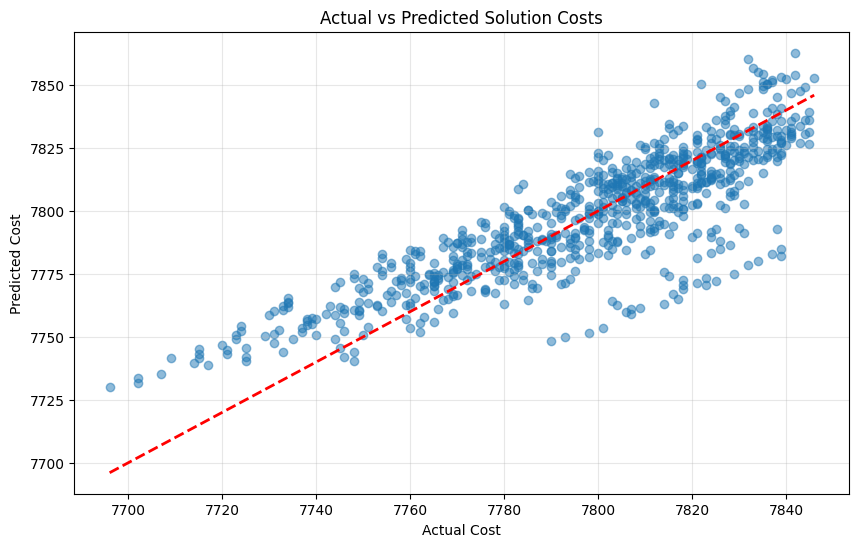

In [18]:
y_pred = reg_model.predict(X_regression)

yhat_0 = [y_regression.min(), y_regression.max()]
yhat_1 = [y_regression.min(), y_regression.max()]

plt.figure(figsize=(10, 6))

plt.scatter(y_regression, y_pred, alpha=0.5)
plt.plot   (yhat_0, yhat_1, 'r--', lw=2)

plt.xlabel("Actual Cost"   )
plt.ylabel("Predicted Cost")
plt.title ("Actual vs Predicted Solution Costs")
plt.grid  (True, alpha=0.3)

plt.show()

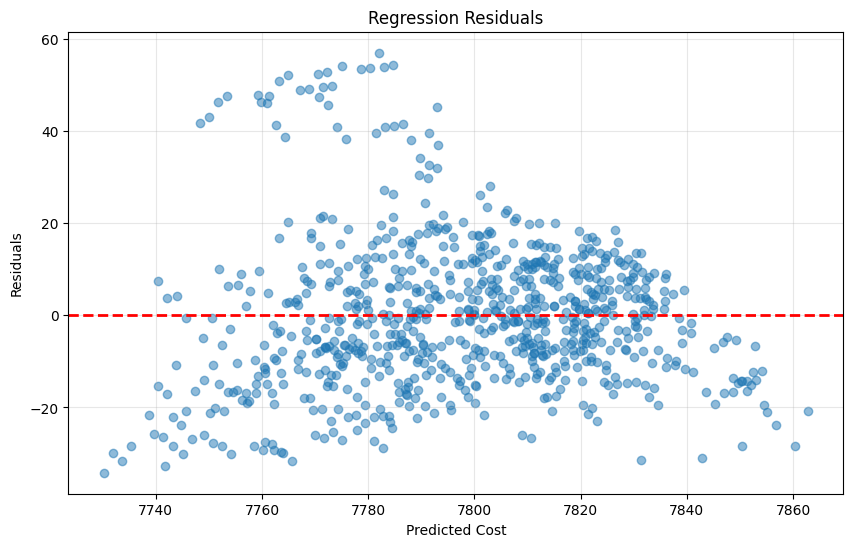

In [19]:
residuals = y_regression - y_pred

plt.figure(figsize=(10, 6))

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)

plt.xlabel("Predicted Cost")
plt.ylabel("Residuals"     )
plt.title ("Regression Residuals")
plt.grid  (True, alpha=0.3)

plt.show()

### REGRESSION ANALYSIS BY DECISION TREE

In [20]:
rng = np.random.RandomState(42)

n     = X_regression.shape[0]
perm  = rng.permutation(n)
split = int(0.8 * n)

train_idx, test_idx = perm[:split], perm[split:]
X_train, y_train = X_regression[train_idx], y_regression[train_idx]
X_test,  y_test  = X_regression[test_idx ], y_regression[test_idx ]

path = DecisionTreeRegressor(
    random_state=42
).cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

cv   = KFold(n_splits=5, shuffle=True, random_state=42)
mses = []
for alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)

    scores = -cross_val_score(
        reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'
    )
    mses.append(scores.mean())

best_alpha = ccp_alphas[np.argmin(mses)]

reg_dt = DecisionTreeRegressor(
    random_state=42, ccp_alpha=best_alpha
)
reg_dt.fit(X_train, y_train)

y_pred_dt = reg_dt.predict(X_test)

rmse = np    .sqrt (mean_squared_error(y_test, y_pred_dt))
r2   = reg_dt.score(X_test, y_test)

print("Decision Tree Regression:")
print()

print(f"R²   = {r2  :.4f}")
print(f"RMSE = {rmse:.3f}")
print(f"Max depth = {reg_dt.get_depth()}, n_leaves = {reg_dt.get_n_leaves()}")

Decision Tree Regression:

R²   = 0.3413
RMSE = 23.717
Max depth = 11, n_leaves = 36


In [21]:
importances = reg_dt.feature_importances_
idx_desc    = np.argsort(importances)[::-1]

top_k   = 10
top_idx = idx_desc[:top_k]

print("Top 10 features:")
print()

for i in top_idx:
    print(f"  Facility {i:3d} = {importances[i]:.4f} ({facility_counts[i]:3d})")

Top 10 features:

  Facility  13 = 0.1239 (279)
  Facility  23 = 0.0898 (341)
  Facility  58 = 0.0767 ( 65)
  Facility  73 = 0.0650 ( 24)
  Facility 203 = 0.0640 ( 43)
  Facility 259 = 0.0549 ( 22)
  Facility  30 = 0.0533 (138)
  Facility 227 = 0.0505 ( 17)
  Facility  99 = 0.0480 ( 36)
  Facility 268 = 0.0464 ( 14)


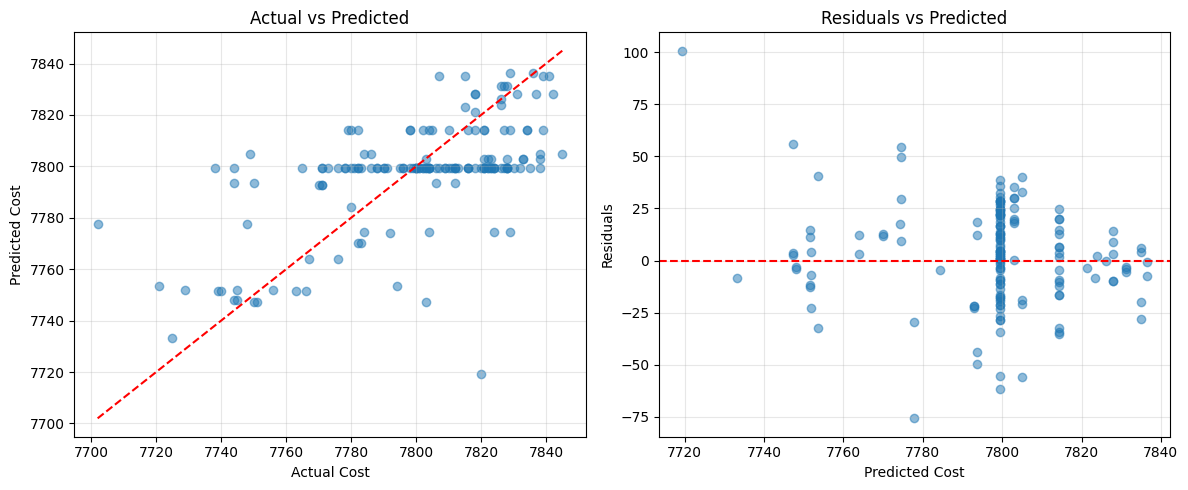

In [22]:
residuals = y_test - y_pred_dt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', lw=1.5)

plt.xlabel("Actual Cost"   )
plt.ylabel("Predicted Cost")
plt.title ("Actual vs Predicted")
plt.grid  (True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_dt, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--', lw=1.5)

plt.xlabel("Predicted Cost")
plt.ylabel("Residuals"     )
plt.title ("Residuals vs Predicted")
plt.grid  (True, alpha=0.3)

plt.tight_layout()

plt.show()